<a href="https://colab.research.google.com/github/michalcik10/SUNS_zadanie1_Steamhry/blob/main/zad3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import os
import tensorflow as tf
from tensorflow.keras import layers 
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow.keras.optimizers as optimizer
import matplotlib.pyplot as pl
from google.colab.patches import cv2_imshow
import numpy
import pandas as pd
import plotly.figure_factory as ffc
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input, decode_predictions
from PIL import Image
from sklearn.pipeline import make_pipeline
from tensorflow.python.keras import backend as kb
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.python.keras.models import Model
from tensorflow.keras.preprocessing.image import load_img

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: ignored

In [27]:
%load_ext tensorboard
import tensorflow as tf
import datetime, os

In [3]:
im_w =100
im_h = 100
train_data_dir = '/content/drive/MyDrive/data-z3/train'
validation_data_dir = '/content/drive/MyDrive/data-z3/valid'
test_data_dir = '/content/drive/MyDrive/data-z3/test'
batch_size = 20

In [6]:
class_names = os.listdir(train_data_dir)
print(class_names)
len_class_names = len(class_names)
print("Number of Classess:",len_class_names)


['giant slalom', 'snow boarding', 'lacrosse', 'surfing', 'bobsled', 'pole climbing', 'arm wrestling', 'golf', 'parallel bar', 'shuffleboard', 'baton twirling', 'uneven bars', 'pole vault', 'water cycling', 'roller derby', 'mushing', 'weightlifting', 'rowing', 'barell racing', 'hydroplane racing', 'field hockey', 'harness racing', 'football', 'canoe slamon', 'jousting', 'shot put', 'sidecar racing', 'disc golf', 'air hockey', 'sky surfing', 'motorcycle racing', 'baseball', 'ice yachting', 'ski jumping', 'cricket', 'horse racing', 'figure skating women', 'javelin', 'bowling', 'billiards', 'figure skating men', 'tug of war', 'horse jumping', 'basketball', 'frisbee', 'sumo wrestling', 'fly fishing', 'cheerleading', 'sailboat racing', 'bull riding', 'rock climbing', 'balance beam', 'polo', 'water polo', 'figure skating pairs', 'volleyball', 'rollerblade racing', 'high jump', 'hang gliding', 'formula 1 racing', 'hockey', 'table tennis', 'pommel horse', 'rugby', 'wingsuit flying', 'ampute foo

In [20]:
import cv2
imag=[]
num_pict=[]
names_clases=[]
for direct in class_names:
    count=0
    im = cv2.imread(train_data_dir + '/' + direct + '/' + os.listdir(train_data_dir + '/' + direct)[0])
    imag.append(im)
    for image in os.listdir(train_data_dir + '/' + direct):
      count+=1
    names_clases.append(direct)
    num_pict.append(count)
    #cv2_imshow(im)
print(names_clases)
print(num_pict)



['giant slalom', 'snow boarding', 'lacrosse', 'surfing', 'bobsled', 'pole climbing', 'arm wrestling', 'golf', 'parallel bar', 'shuffleboard', 'baton twirling', 'uneven bars', 'pole vault', 'water cycling', 'roller derby', 'mushing', 'weightlifting', 'rowing', 'barell racing', 'hydroplane racing', 'field hockey', 'harness racing', 'football', 'canoe slamon', 'jousting', 'shot put', 'sidecar racing', 'disc golf', 'air hockey', 'sky surfing', 'motorcycle racing', 'baseball', 'ice yachting', 'ski jumping', 'cricket', 'horse racing', 'figure skating women', 'javelin', 'bowling', 'billiards', 'figure skating men', 'tug of war', 'horse jumping', 'basketball', 'frisbee', 'sumo wrestling', 'fly fishing', 'cheerleading', 'sailboat racing', 'bull riding', 'rock climbing', 'balance beam', 'polo', 'water polo', 'figure skating pairs', 'volleyball', 'rollerblade racing', 'high jump', 'hang gliding', 'formula 1 racing', 'hockey', 'table tennis', 'pommel horse', 'rugby', 'wingsuit flying', 'ampute foo

In [23]:
import plotly.express as px
fig_train_data = pd.DataFrame(os.listdir(train_data_dir)).copy()
fig = px.histogram(fig_train_data, x=class_names, y=num_pict).update_layout(
    title='Train data: Number of reprezentants in category ', yaxis_title="Pictures", xaxis_title="Class Name", bargap=0.5)
fig.show()

Reprezentant from class

<ipython-input-5-77a3a9390a89>:6: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.subplot(10, 10, i + 1)


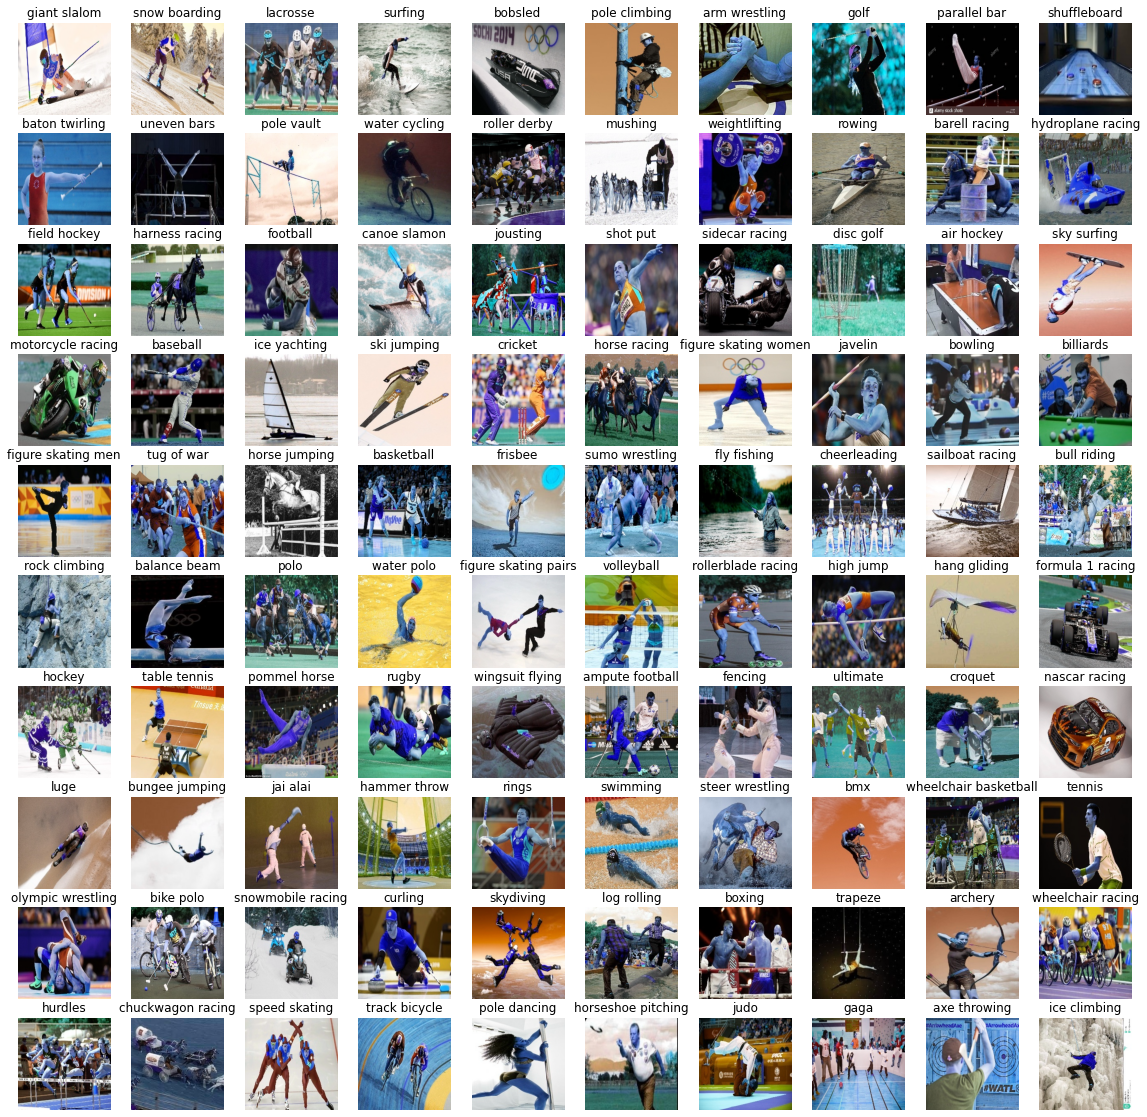

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 20))
for images in imag:
  for i in range(100):
    ax = plt.subplot(10, 10, i + 1)
    plt.imshow(imag[i])
    plt.title(class_names[i])
    plt.axis("off")

In [25]:
train_dataset = tf.keras.utils.image_dataset_from_directory(
  train_data_dir,
  image_size=(im_h, im_w),
  batch_size=batch_size)

validation_dataset = tf.keras.utils.image_dataset_from_directory(
    validation_data_dir, 
    image_size=(im_h, im_w),
    batch_size=batch_size)

test_dataset = tf.keras.utils.image_dataset_from_directory(
    test_data_dir, image_size=(im_w, im_h), batch_size=batch_size, shuffle=False)


Found 13619 files belonging to 100 classes.
Found 500 files belonging to 100 classes.
Found 500 files belonging to 100 classes.


In [ ]:
print(train_dataset)

<BatchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


In [26]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2)

In [27]:
train_generator = train_datagen.flow_from_directory(
    directory=train_data_dir,
    target_size=(im_w, im_h),
    batch_size=batch_size,
    color_mode="rgb",
    class_mode="categorical"
)

Found 13619 images belonging to 100 classes.


In [28]:
validation_generator = train_datagen.flow_from_directory(
    directory=validation_data_dir,
    target_size=(im_w, im_h),
    batch_size=batch_size,
    color_mode="rgb",
    class_mode="categorical"
)

Found 500 images belonging to 100 classes.


In [29]:
test_generator = train_datagen.flow_from_directory(
    directory=test_data_dir,
    target_size=(im_w, im_h),
    batch_size=batch_size,
    color_mode="rgb",
    class_mode="categorical",
    shuffle=False
)

Found 500 images belonging to 100 classes.


In [30]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.cache().prefetch(buffer_size=AUTOTUNE)
# test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [31]:
class_names = list(train_generator.class_indices.keys()) 
print(len(class_names))

100


In [32]:
data_augmentation = Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(im_h,
                                  im_w,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

In [35]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

KeyboardInterrupt: ignored

<Figure size 720x720 with 0 Axes>

MobileNetV2 clasification on one image

In [16]:
model = MobileNetV2(
    input_shape=None,
    alpha=1.0,
    include_top=True,
    weights="imagenet",
    input_tensor=None,
    pooling=None,
    classes=1000,
    classifier_activation="softmax"
)

14536120/14536120 [==============================] - 0s 0us/step


Archery clasification

In [17]:
archery_data = numpy.empty((1, 224, 224, 3))
archery_data[0] = cv2.imread(train_data_dir + '/' + 'archery' + '/' + '011.jpg')
# print(data[0])
archery_data = preprocess_input(archery_data)

predictions = model.predict(archery_data)
print('Shape: {}'.format(predictions.shape))

1/1 [==============================] - 8s 8s/step
Shape: (1, 1000)


In [18]:
out_neuron = numpy.argmax(predictions[0])
print('Most active neuron: {} ({:.2f}%)'.format(out_neuron, 100 * predictions[0][out_neuron]
))

Most active neuron: 456 (80.56%)


In [19]:
for name, desc, score in decode_predictions(predictions)[0]:
    print('Class : {} ({:.2f}%)'.format(desc.upper(), 100 * score))

35363/35363 [==============================] - 0s 0us/step
Class : BOW (80.56%)
Class : MOUNTAIN_BIKE (1.10%)
Class : BREASTPLATE (1.05%)
Class : BARBELL (1.01%)
Class : HAND_BLOWER (0.71%)


In [20]:
golf_data = numpy.empty((1, 224, 224, 3))
# golf_data[0] = cv2.imread(train_data_dir + '/' + 'golf' +'/' + '005.jpg')
golf_data[0] = cv2.imread(train_data_dir + '/' + 'golf' +'/' + '025.jpg')
# print(data[0])
golf_data = preprocess_input(golf_data)

predictions = model.predict(golf_data)
print('Shape: {}'.format(predictions.shape))

1/1 [==============================] - 0s 22ms/step
Shape: (1, 1000)


In [21]:
out_neuron = numpy.argmax(predictions[0])
print
print('Most active neuron: {} ({:.2f}%)'.format(
    out_neuron, 100 * predictions[0][out_neuron]
))

Most active neuron: 574 (24.12%)


In [24]:
score_arr=[]
category_arr=[]
for name, desc, score in decode_predictions(predictions)[0]:
    print('Class : {} ({:.2f}%)'.format(desc.upper(), 100 * score))
    category_arr.append(desc)
    score_arr.append(100*score)
print(category_arr)
print(score_arr)

NameError: ignored

In [23]:
if kb.image_data_format() == 'channels_first':
    input_sh = (3, im_w, im_h)
else:
    input_sh = (im_w, im_h, 3)

model1 = Sequential()
model1.add(layers.RandomFlip("horizontal", input_shape=input_sh))
model1.add(layers.RandomRotation(0.1))
model1.add(layers.RandomZoom(0.1))
model1.add(layers.Rescaling(1./255))
model1.add(layers.Conv2D(16, 3, padding='same', activation='relu', input_shape=input_sh))
model1.add(layers.MaxPooling2D())
model1.add(layers.Conv2D(32, 3, padding='same', activation='relu'))
model1.add(layers.MaxPooling2D())
model1.add(layers.Conv2D(128, 3, padding='same', activation='relu'))
model1.add(layers.MaxPooling2D())
model1.add(layers.Dropout(0.4))
model1.add(layers.Flatten())
model1.add(layers.Dense(128, activation='relu'))
model1.add(layers.Dense(100, name="outputs"))

In [24]:
model1.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [25]:
model1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip_1 (RandomFlip)  (None, 100, 100, 3)       0         
                                                                 
 random_rotation_1 (RandomRo  (None, 100, 100, 3)      0         
 tation)                                                         
                                                                 
 random_zoom_1 (RandomZoom)  (None, 100, 100, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 100, 100, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 100, 100, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 50, 50, 16)       0         
 )                                                    

In [28]:
checkpoint_filepath = '/tmp/checkpoint'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

early_stopping = EarlyStopping(monitor='loss', patience=3)
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

epochs = 15
history = model1.fit(
  train_dataset,
  validation_data=validation_dataset,
  epochs=epochs,
  callbacks=[model_checkpoint_callback, early_stopping]
)

model1.load_weights(checkpoint_filepath)

Epoch 1/15
681/681 [==============================] - 24s 31ms/step - loss: 4.1056 - accuracy: 0.0673 - val_loss: 3.7327 - val_accuracy: 0.1140
Epoch 2/15
681/681 [==============================] - 9s 13ms/step - loss: 3.3147 - accuracy: 0.1902 - val_loss: 3.1317 - val_accuracy: 0.2560
Epoch 3/15
681/681 [==============================] - 9s 13ms/step - loss: 2.8898 - accuracy: 0.2719 - val_loss: 2.8296 - val_accuracy: 0.2940
Epoch 4/15
681/681 [==============================] - 9s 13ms/step - loss: 2.6276 - accuracy: 0.3277 - val_loss: 2.6565 - val_accuracy: 0.3440
Epoch 5/15
681/681 [==============================] - 9s 13ms/step - loss: 2.4593 - accuracy: 0.3627 - val_loss: 2.4569 - val_accuracy: 0.3940
Epoch 6/15
681/681 [==============================] - 9s 13ms/step - loss: 2.3155 - accuracy: 0.3933 - val_loss: 2.4251 - val_accuracy: 0.3780
Epoch 7/15
681/681 [==============================] - 9s 13ms/step - loss: 2.2144 - accuracy: 0.4220 - val_loss: 2.5218 - val_accuracy: 0.410

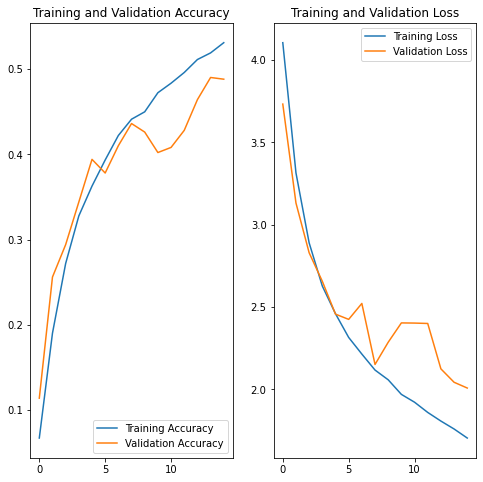

In [29]:
import matplotlib.pyplot as pl

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

pl.figure(figsize=(8, 8))
pl.subplot(1, 2, 1)
pl.plot(epochs_range, acc, label='Training Accuracy')
pl.plot(epochs_range, val_acc, label='Validation Accuracy')
pl.legend(loc='lower right')
pl.title('Training and Validation Accuracy')

pl.subplot(1, 2, 2)
pl.plot(epochs_range, loss, label='Training Loss')
pl.plot(epochs_range, val_loss, label='Validation Loss')
pl.legend(loc='upper right')
pl.title('Training and Validation Loss')
pl.show()

In [30]:
y_predict_test = model1.predict(test_dataset)
y_predict_test = numpy.argmax(y_predict_test, axis=1)
print(y_predict_test)

25/25 [==============================] - 10s 391ms/step
[ 0  0  0  0 15 12  1 16 42 53  2  2 38 60 15 74  3 62  3  3 67  4  4 19
 56  5  5  5  5  5  6 83  6  6  6 25 31 39 58  5 73 83  8 16 15 49 74  2
 49  9 10 90 10 10 56 11 71 86 11 11 12 77 12 56 78 80 80 32 80 32  9 14
 25 74 74 15 15 15 15 15 16 16 16 16 16 67 78 58 35 24 35 18 78 80 80 35
 51  2 90  8 10 20 20 20 16 31 21 12 21 21 22 21 64 22 21 23 23 23 23 23
 24 24 24 12 24 86 15 52 25 41 26 31 26 26 52 27 27 28 27 27 29 28 66 28
 28 29 29 29 29 29 24 24 16 10 24 31 71 53 31 31 32 32 32 32 58 12 65 76
 61 29 21 10 51 15 40 35 35 35 35 35 40 53 36 44 33 16 37  6 96 96 78 35
 38 38 78 39 12 39 39 39 40 40 40 40 59 41 41 41 41 41 97 97 16 15 42 39
 39 43 43 43  6 96 91 37 42 18 41 93 75 45 75 71 15 46 46 47 47 47 47 80
 80 48 48 48 48 96 87 53 99 69 59 15 32 15 40 90 51 51 51 51 52 54 52 52
 52 53 53 71 53 21 42 85 16 39 16 55 55 55 55 78 75 56 75 32 56 57 57 57
 41 57 58 58 58 58 58 59 59 59 59 59 60 92 60 59 92  6 61 61 61 61 6

In [31]:
score = model1.evaluate(test_dataset)
print(score)

25/25 [==============================] - 0s 9ms/step - loss: 2.0284 - accuracy: 0.5060
[2.0283825397491455, 0.5059999823570251]


In [ ]:
report = classification_report(test_dataset, y_predict_test)
print(report) 

ValueError: ignored

In [32]:
predictions = numpy.array([])
labels = numpy.array([])

for image_batch, labels_batch in test_dataset:
    labels = numpy.append(labels, labels_batch)
    batch_predictions = model1.predict(image_batch)
    predictions = numpy.concatenate([predictions, numpy.argmax(batch_predictions, axis=1)])

1/1 [==============================] - 0s 19ms/step


In [33]:
import plotly.graph_objects as go

matrix = confusion_matrix(labels, predictions)
fig = go.Figure (data=go.Heatmap(
    z=matrix, x=class_names, 
    y=class_names,hoverongaps = False))
fig.write_html('matrix.html')

In [34]:
from tensorflow.keras.preprocessing.image import img_to_array

from tensorflow.keras.preprocessing.image import load_img


model = VGG16(include_top=False, weights='imagenet', input_shape=(im_w, im_h,3))


save_csv = []
save_csv2 = []


for category in os.listdir(train_data_dir):
    for filename in os.listdir(train_data_dir + '/' + category):
        if filename.endswith('.jpg'):
            full_path = train_data_dir + '/' + category + '/' + filename

            img = load_img(full_path, target_size=(100, 100))
            image_arr = img_to_array(img)
            image_arr = numpy.expand_dims(image_arr, axis=0)
            image_arr = preprocess_input(image_arr)

            features = model.predict(image_arr).ravel().tolist()

            item = list(class_names).index(category)
            features.insert(0, item)
            save_csv.append(features)

features_data_train = [*range(0, len(save_csv[0]) - 1)]
features_data_train.insert(0, 'label')

save_csv = pd.DataFrame(save_csv, columns=features_data_train)
save_csv.to_csv('train.csv', index=False)

for category in os.listdir(test_data_dir):
    for filename in os.listdir(test_data_dir + '/' + category):
        if filename.endswith('.jpg'):
            full_path = test_data_dir + '/' + category + '/' + filename

            img = load_img(full_path, target_size=(100, 100))
            image_arr = img_to_array(img)
            image_arr = numpy.expand_dims(image_arr, axis=0)
            image_arr = preprocess_input(image_arr)

            features = model.predict(image_arr).ravel().tolist()

            item = list(class_names).index(category)
            features.insert(0, item)
            save_csv2.append(features)

features_data_test = [*range(0, len(save_csv2[0]) - 1)]
features_data_test.insert(0, 'label')

save_csv2 = pd.DataFrame(save_csv, features_data_test)
save_csv2.to_csv('test.csv', index=False)

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 19ms/step


In [ ]:
%tensorboard --logdir logs

In [ ]:
from tensorboard import notebook
notebook.list() # View open TensorBoard instances

In [ ]:
import pandas as pd

train_data = pd.read_csv('train.csv')
x_train_data = train_data.drop(columns=['label'])
y_train_data = train_data['label']

test_data = pd.read_csv('test.csv')
x_test_data = test_data.drop(columns=['label'])
y_test_data = test_data['label']

scater = StandardScaler()
scater.fit(x_train_data)
x_train_data = scater.transform(x_train_data)
x_test_data = scater.transform(x_train_data)

In [ ]:

clf = SVC()
clf.fit(x_train_data, y_train_data)
yTestPredict = clf.predict(x_test_data).round()
print('SVC score: ' + str(clf.score(x_test_data, y_test_data)))

ValueError: ignored

In [ ]:
matrix = confusion_matrix(y_train_data.values, yTestPredict)
fig = go.Figure(data=go.Heatmap(
    z=matrix,
    x=class_names,
    y=class_names,
    hoverongaps=False))
fig.write_html('matrixSVC.html')